# CS4035 - Cyber Data Analytics
## Lab 2 - PCA/Regression task

## Group Number : 21

## Student 2
### Name : Michał Okoń
### ID :

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import ccf

In [107]:
# If this cell does not work try running ``

import io
import nbformat

nb = nbformat.read("Lab2-PCA-Regression.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 466


## 0. Data Loading

#### Loading into pandas dataframe

In [2]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

In [109]:
# Excluding the time frame and the target variable and backup signals
relevant_signals = ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401',
                    'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
                    'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'MV101', 'P101', 'MV201', 'P203', 'P205', 'MV301',
                    'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P402', 'UV401', 'P501', 'P602']
relevant_train_data_df = train_data_df[relevant_signals]
relevant_train_data_df

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV301,MV302,MV303,MV304,P301,P302,P402,UV401,P501,P602
Id,,,,,,,,,,,,,,,,,,,,,
0,2.470294,261.5804,244.3284,8.190080,306.1010,2.471278,20.79839,2.235275,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
1,2.457163,261.1879,244.3284,8.190080,306.1010,2.468587,20.79839,2.234507,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
2,2.439548,260.9131,244.3284,8.190080,306.1010,2.467305,20.84320,2.233354,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
3,2.428338,260.2850,244.3284,8.190080,306.1010,2.466536,20.84320,2.233354,327.2799,0.000,...,1,2,1,1,2,1,1,1,1,1
4,2.424815,259.8925,244.4245,8.190080,306.1010,2.466536,20.84320,2.233354,327.1597,0.000,...,1,2,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496795,2.460366,523.0430,262.0161,8.396437,328.5055,2.442316,19.74838,2.212087,955.8046,148.808,...,1,2,1,1,1,2,2,2,2,1
496796,2.448836,522.9645,262.0161,8.396437,328.5055,2.442316,19.74838,2.210037,955.8847,148.808,...,1,2,1,1,1,2,2,2,2,1
496797,2.434744,522.8860,262.0161,8.396437,328.6337,2.444879,19.74838,2.207731,955.9648,148.808,...,1,2,1,1,1,2,2,2,2,1


In [110]:
test_data_df

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
Id,,,,,,,,,,,,,,,,,,,,,
224959,31/12/2015 12:29:19 AM,2.612177,517.6261,2,2,1,192.2263,8.530376,324.2758,2.443597,...,0.306825,2,1,250.0000,0.816967,188.4613,0.0,1,1,1
224960,31/12/2015 12:29:20 AM,2.612177,517.7831,2,2,1,192.2263,8.531017,324.2758,2.443597,...,0.306441,2,1,250.0000,0.816967,188.4613,0.0,1,1,1
224961,31/12/2015 12:29:21 AM,2.594562,518.2149,2,2,1,192.2263,8.531017,324.2758,2.443597,...,0.306441,2,1,249.9840,0.816967,188.4613,0.0,1,1,1
224962,31/12/2015 12:29:22 AM,2.577907,518.7645,2,2,1,192.2263,8.531017,324.2758,2.442060,...,0.306441,2,1,249.7597,0.816967,188.4613,0.0,1,1,1
224963,31/12/2015 12:29:23 AM,2.562854,519.1177,2,2,1,192.2263,8.531017,324.2758,2.441419,...,0.306441,2,1,249.7597,0.816967,188.4613,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,...,0.306569,2,1,251.1535,0.865024,189.0220,0.0,1,1,1
449915,2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,...,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1
449916,2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,...,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1


## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

Main functions used to perform the PCA and plot the residuals.

In [111]:
def get_pca_residuals(df, components=None):
    total_residuals = []
    if components is None:
        component_range = range(1, len(df.columns))
    else:
        component_range = components
    for n_components in component_range:
        pca = PCA(n_components=n_components)
        pca.fit(df)
        # Calculate residuals
        residuals = calculate_residuals(df, pca)
        total_residuals.append(residuals)
    return total_residuals


def plot_pca_residuals(residuals, components, start_index=0, true_labels=None, predicted_labels=None):
    plt.clf()
    x = np.arange(start_index, len(residuals[0]))
    for i, residual in enumerate(residuals):
        plt.plot(x, residual[start_index:], label=f'{components[i]}')
    if true_labels is not None:
        plt.vlines(true_labels, ymin=-2, ymax=2, colors='r', linestyles='dashed')
    if predicted_labels is not None:
        plt.vlines(predicted_labels, ymin=-1, ymax=1, colors='b', linestyles='dashed')
    plt.legend()
    plt.title('PCA Residuals for different number of components')
    plt.show()

def calculate_residuals(df, pca):
    return np.sum(np.abs(df - pca.inverse_transform(pca.transform(df))), axis=1)

Perform the residual analysis.

In [112]:
components = np.arange(1, len(relevant_train_data_df.columns))

In [113]:
residuals = get_pca_residuals(relevant_train_data_df)

In [114]:
partial_components1 = [1, 2, 5]
partial_residuals1 = get_pca_residuals(relevant_train_data_df, components=partial_components1)

In [115]:
partial_components2 = [10, 15, 20]
partial_residuals2 = get_pca_residuals(relevant_train_data_df, components=partial_components2)

In [116]:
partial_components3 = [25, 30, 35]
partial_residuals3 = get_pca_residuals(relevant_train_data_df, components=partial_components3)

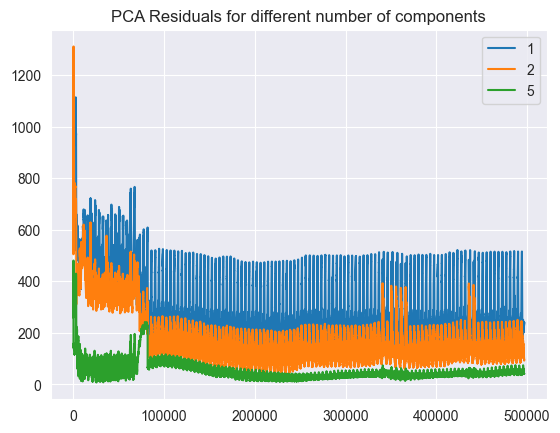

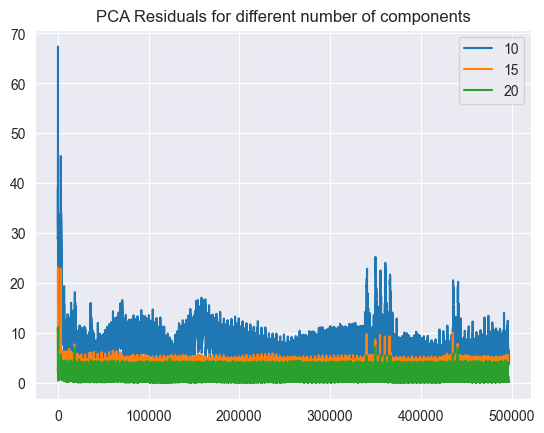

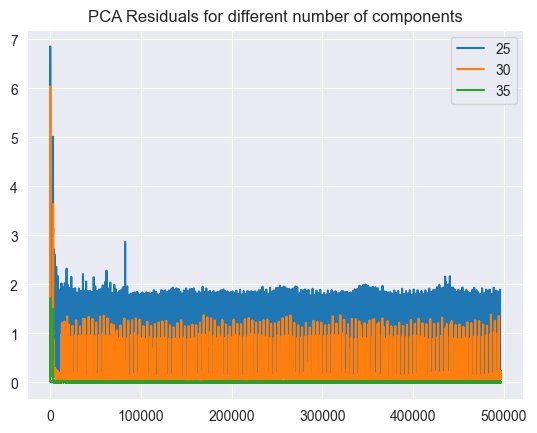

In [117]:
plot_pca_residuals(partial_residuals1, partial_components1, start_index=0)
plot_pca_residuals(partial_residuals2, partial_components2, start_index=0)
plot_pca_residuals(partial_residuals3, partial_components3, start_index=0)

In [118]:
# plot_pca_residuals(residuals, start_index=50000)

Analyzing the residuals in the train set.

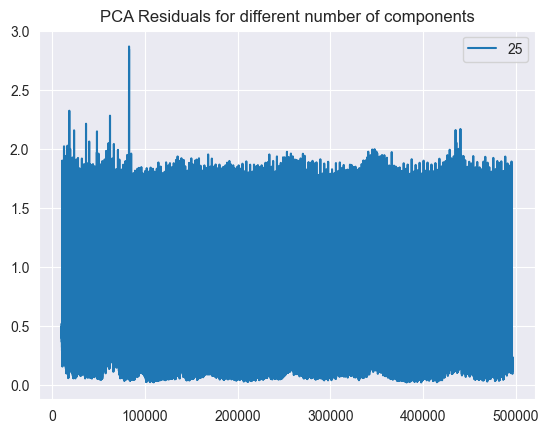

In [119]:
final_components = 25 # 25 good
start_index = 10000
final_pca = PCA(n_components=final_components)
final_pca.fit(relevant_train_data_df)
train_data_pca = final_pca.transform(relevant_train_data_df)
# Calculate residuals
residuals = calculate_residuals(relevant_train_data_df, final_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=start_index)

Plotting residuals from the test set. From the values below, it can be noted that the threshold between 4 and 5 is a good choice as it captures just enough outliers in the data.

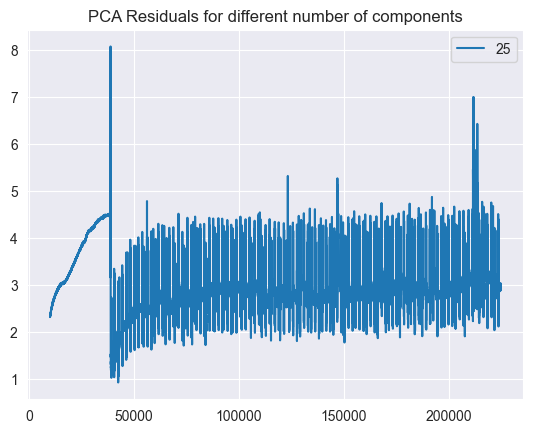

In [120]:
relevant_test_data_df = test_data_df[relevant_signals]

test_data_pca = final_pca.transform(relevant_test_data_df)
# Calculate residuals
residuals = calculate_residuals(relevant_test_data_df, final_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=start_index)

In [121]:
#

Plotting residuals from the validation dataset and marking anomalies (red dashed vertical lines). As can be seen, some anomalies are properly detected. This is used to verify the submission for kaggle.

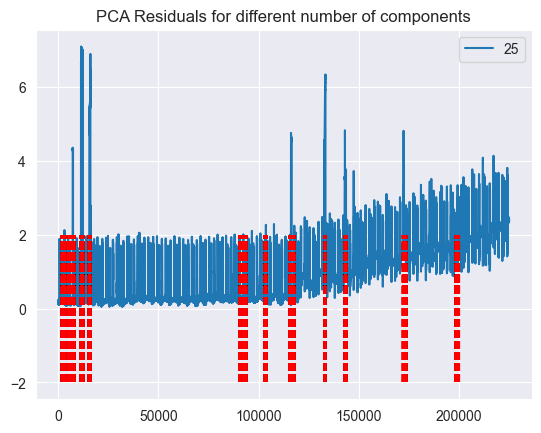

In [122]:
relevant_validation_data_df = val_data_df[relevant_signals]
validation_data_pca = final_pca.transform(relevant_validation_data_df)
# Calculate residuals
validation_residuals = calculate_residuals(relevant_validation_data_df, final_pca)

# Get indices of anomalies
anomaly_indices = np.where((val_data_df['Label'].to_numpy() == 1))[0]
plot_pca_residuals([validation_residuals], components=[final_components], start_index=0, true_labels=anomaly_indices)

Defining the allowed range for each of the signal which is set to be (1.5 * smallest_signal_residual, 1.5 * largest_signal_residual) to provide some safety margin. If the residual of a signal is out of this range, then the signal is considered an anomaly.

In [123]:
def calculate_thresholds(residuals, range_multiplier=1.5):
    return residuals.max() * range_multiplier

start_signal = 10000
trimmed_train_data_df = relevant_train_data_df.iloc[start_signal:, :]
train_residuals = calculate_residuals(trimmed_train_data_df, final_pca)
threshold = calculate_thresholds(train_residuals, range_multiplier=1.5)
print(threshold)

4.301609497302628


In [124]:
print(validation_residuals)

Id
0         0.184758
1         0.146763
2         0.145627
3         0.176135
4         0.202569
            ...   
224954    2.338033
224955    2.339943
224956    2.355958
224957    2.423998
224958    2.423238
Length: 224959, dtype: float64


In [127]:
def find_anomalies_in_residuals(residuals, threshold):
    """
    Returns the set containing indices of anomalies in the residuals.
    """
    anomalies_indices = set()
    # Return indices where the residual is out of the allowed range using numpy
    for i, residual in enumerate(residuals):
        if residual > threshold:
            anomalies_indices.add(i)
    return anomalies_indices


predicted_anomalies = list(find_anomalies_in_residuals(validation_residuals, threshold))


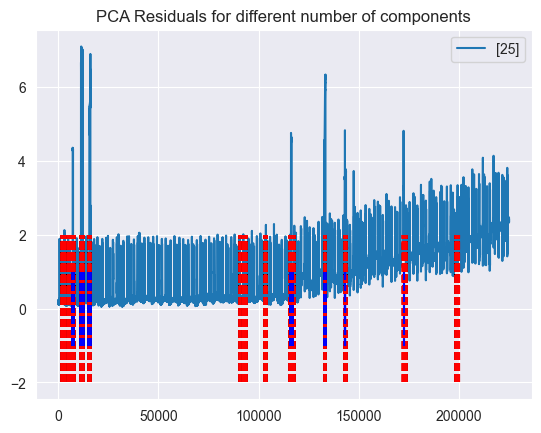

In [128]:
plot_pca_residuals([validation_residuals], components= [[25]], start_index=0, true_labels=anomaly_indices,
                   predicted_labels=predicted_anomalies)

Calculate metrics for the PCA model.

In [129]:
# Calculate the number of true positives, false positives, true negatives and false negatives
def calculate_statistics(predicted_anomalies, true_anomalies):
    true_positives = len(set(predicted_anomalies).intersection(set(true_anomalies)))
    false_positives = len(set(predicted_anomalies).difference(set(true_anomalies)))
    true_negatives = len(
        set(np.arange(len(validation_residuals.index))).difference(set(predicted_anomalies).union(set(true_anomalies))))
    false_negatives = len(set(true_anomalies).difference(set(predicted_anomalies)))
    return true_positives, false_positives, true_negatives, false_negatives


tp, fp, tn, fn = calculate_statistics(predicted_anomalies, anomaly_indices)
print(f"True positives: {tp}, False positives: {fp}, True negatives: {tn}, False negatives: {fn}")


def calculate_metrics(tp, fp, tn, fn):
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    return accuracy, precision, recall, f1_score


accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}")


True positives: 2177, False positives: 59, True negatives: 213864, False negatives: 8859
Accuracy: 0.960357220649096, Precision: 0.973613595706619, Recall: 0.19726350126857556, F1 score: 0.3280590717299578


Analyze several thresholds. Turns out that multiplying the max and min values in the train set by 4 gives the best results.

In [130]:
def analyze_thresholds(residuals, true_anomalies, thresholds, range_multipliers):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    for i, threshold in enumerate(thresholds):
        predicted_anomalies = list(find_anomalies_in_residuals(residuals, threshold))
        tp, fp, tn, fn = calculate_statistics(predicted_anomalies, true_anomalies)
        accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        print(
            f"Threshold multiplier: {range_multipliers[i]}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}\n")
    return accuracies, precisions, recalls, f1_scores


threshold_multipliers = np.arange(0.4, 3, 0.2)
thresholds = [calculate_thresholds(train_residuals, range_multiplier=multiplier) for multiplier in
              threshold_multipliers]
accuracies, precisions, recalls, f1_scores = analyze_thresholds(validation_residuals, anomaly_indices, thresholds,
                                                                threshold_multipliers)

Threshold multiplier: 0.4, Accuracy: 0.6667437177441222, Precision: 0.07728012060142024, Recall: 0.5295396882928597, F1 score: 0.1348765823880356

Threshold multiplier: 0.6000000000000001, Accuracy: 0.8455051809440831, Precision: 0.1381319989015348, Recall: 0.41020297209133744, F1 score: 0.20666986235704993

Threshold multiplier: 0.8000000000000002, Accuracy: 0.9539827257411351, Precision: 0.5580448065173116, Recall: 0.2979340340703153, F1 score: 0.38846880907372394

Threshold multiplier: 1.0000000000000002, Accuracy: 0.9637267235362889, Precision: 0.8935413245758074, Recall: 0.2958499456324755, F1 score: 0.4445200816882232

Threshold multiplier: 1.2000000000000002, Accuracy: 0.9642734898359256, Precision: 0.954531676265535, Recall: 0.2853388909025009, F1 score: 0.439344262295082

Threshold multiplier: 1.4000000000000004, Accuracy: 0.9614774247751813, Precision: 0.9683794466403162, Recall: 0.2220007249003262, F1 score: 0.36119711042311664

Threshold multiplier: 1.6000000000000005, Accu

In [133]:
# Find anomalies in the test data
test_residuals = calculate_residuals(relevant_test_data_df, final_pca)
test_threshold = 4.8
test_anomalies = np.array(find_anomalies_in_residuals(test_residuals, test_threshold)) + start_index

# Create an array with all the original indices and test anomalies as labels
test_labels = np.zeros(len(test_residuals) + start_index)
test_labels[test_anomalies] = 1
# Create a dataframe with the indices of the anomalies
test_anomalies_df = pd.DataFrame([np.arange(len(test_residuals) + start_index), test_labels], columns=["index", "ore"])
# Put the anomalies in a dataframe
print(test_anomalies)

[213705, 213706, 123366, 123367, 6798, 6799, 6800, 6801, 6802, 211631, 211632, 211633, 211634, 211635, 211636, 211637, 211638, 211639, 211640, 211641, 211642, 211643, 211644, 211645, 211646, 211647, 211648, 211649, 211650, 211651, 211652, 211653, 211654, 211655, 211656, 211657, 211658, 211659, 211660, 211661, 211662, 211663, 211664, 211665, 211666, 211667, 211668, 211669, 211670, 211671, 211672, 211673, 211674, 211675, 211676, 211677, 211678, 211679, 211680, 211681, 211682, 211683, 211684, 211685, 211686, 211687, 211688, 211689, 211690, 211691, 211692, 211693, 211694, 211695, 211696, 211697, 211698, 211699, 211700, 211701, 211702, 211703, 211704, 211705, 211706, 211707, 211708, 211709, 211710, 211711, 211712, 211713, 211714, 211715, 211716, 211717, 211718, 211719, 211720, 211721, 211722, 211723, 211724, 211725, 211726, 211727, 211728, 211729, 211730, 211731, 211732, 211733, 211734, 211735, 211736, 211737, 211738, 211739, 211740, 211741, 211742, 211743, 211744, 211745, 211746, 211747, 2

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Individual

FIT101 displays interesting temporal behavior.

### 4a. Print relevant plots and/or metrics to determine the parameters.

In [3]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

start_index = 10000
relevant_train_data_df = train_data_df.iloc[start_index:, :]
relevant_val_data_df = val_data_df.iloc[start_index:, :]
relevant_test_data_df = test_data_df.iloc[start_index:, :]

<Figure size 640x480 with 0 Axes>

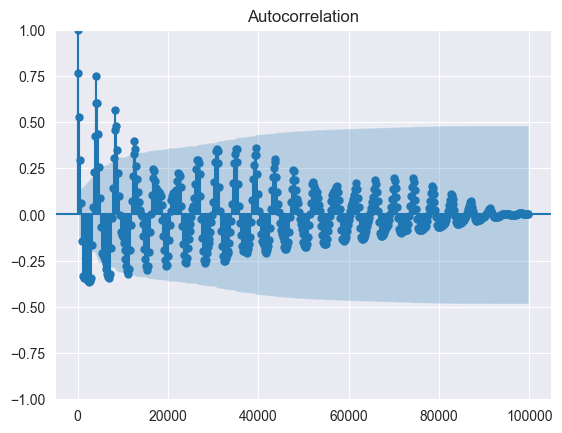

In [4]:
# Plot the autocorrelations for the relevant attributes
start_time = 10000
plotting_time = 100000
plt.clf()
plot_acf(relevant_train_data_df[["FIT101"]].iloc[: plotting_time,:], lags=list(range(0, plotting_time, 200)))
plt.show()

As can be seen in the plot above, the signal shows some cyclic behavior.

In [5]:
from statsmodels.tsa.stattools import acf

fit101_acf = acf(relevant_train_data_df[["FIT101"]].iloc[: plotting_time,:], nlags=plotting_time)[::200]
# Find 10 largest values in the acf
print(fit101_acf)
largest_acf_values = np.argsort(fit101_acf, axis=0)[-10:]
print(f"10 largest values in the acf: {largest_acf_values*200}")

[ 1.00000000e+00  7.63081602e-01  5.29141835e-01  2.93594062e-01
  6.37937413e-02 -1.44368784e-01 -3.33698395e-01 -3.45618389e-01
 -3.46219512e-01 -3.37306164e-01 -3.41345791e-01 -3.51086139e-01
 -3.59139737e-01 -3.67651123e-01 -3.61817880e-01 -3.41374859e-01
 -1.64781376e-01  3.90559823e-02  2.32262960e-01  4.25688904e-01
  6.04754704e-01  7.47899266e-01  6.04738460e-01  4.33241078e-01
  2.59493779e-01  8.77943172e-02 -6.59622805e-02 -2.07254553e-01
 -2.21167827e-01 -2.31317070e-01 -2.46971393e-01 -2.68492643e-01
 -2.96338113e-01 -3.20137922e-01 -3.38419694e-01 -3.42493694e-01
 -3.19694374e-01 -1.81794002e-01 -1.75066719e-02  1.44884134e-01
  3.07615838e-01  4.56451616e-01  5.65339375e-01  4.76682499e-01
  3.46695518e-01  2.23696564e-01  1.02392699e-01 -1.14062616e-03
 -9.45929348e-02 -1.12301678e-01 -1.23106596e-01 -1.52426487e-01
 -1.93636791e-01 -2.41671099e-01 -2.80088923e-01 -3.05460643e-01
 -3.22134532e-01 -2.97363320e-01 -1.91123203e-01 -5.73468109e-02
  7.53353154e-02  2.07498

In [6]:
start_lag = 1
end_lag = 5001
interval = 500

From the analysis above, we can deduce that the period of this signal is around 4200 as the autocorrelation has a large spike there. Thus, our first attempt will consider lags around this value.

In [4]:
# Use autoregression to predict the next values based on the previous ones
from statsmodels.tsa.ar_model import AutoReg
zero_indexed_train_df = relevant_train_data_df.reset_index(inplace=False, drop=True)
lags = [3800, 3900, 4000, 4100, 4200, 4300, 4400]
fit101_ar = AutoReg(zero_indexed_train_df["FIT101"], lags=lags).fit()
max_lag = np.max(lags)

In [79]:
def get_ar_residuals(ar_model,  data, params = None):
    if params is None:
        return data.to_numpy().squeeze() -  ar_model.predict(start=0, dynamic=False)
    else:
        return data.to_numpy().squeeze()- ar_model.predict(params, start=0, dynamic=False)

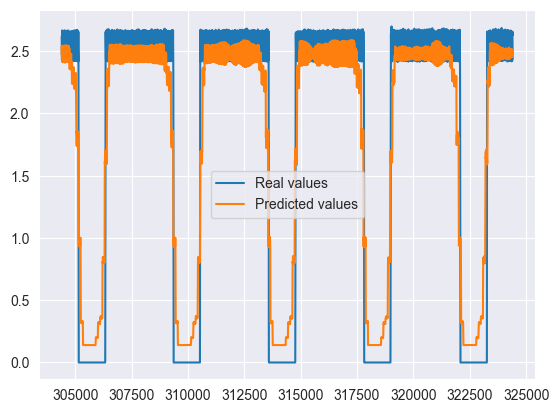

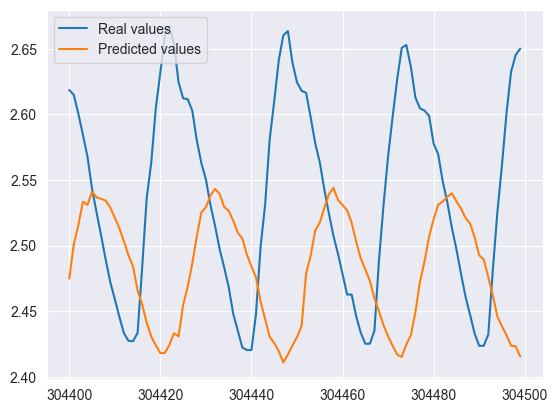

In [51]:
# Plot the predicted and real values
plt.clf()
plt.plot(zero_indexed_train_df["FIT101"][max_lag:][300000:320000], label="Real values")
plt.plot(fit101_ar.predict(start=max_lag, dynamic=False)[300000:320000], label="Predicted values")
plt.legend()
plt.show()

plt.clf()
plt.plot(zero_indexed_train_df["FIT101"][max_lag:][300000:300100], label="Real values")
plt.plot(fit101_ar.predict(start=max_lag, dynamic=False)[300000:300100], label="Predicted values")
plt.legend()
plt.show()

As can be seen above, the predicted and real values are close to the real ones on larger scale.

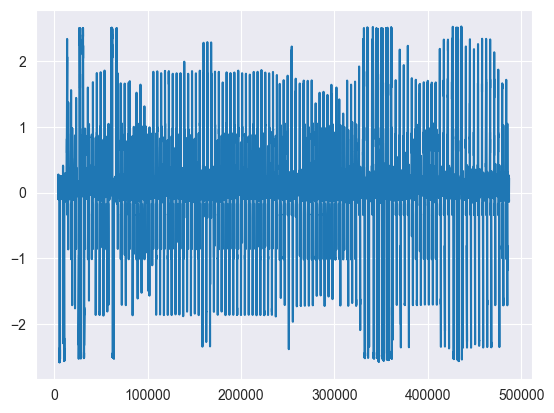

In [45]:
plt.clf()

train_residuals = get_ar_residuals(fit101_ar, zero_indexed_train_df["FIT101"])
plt.plot(train_residuals)

Residuals confirm that the difference between the predicted and true values is rather small. We will now look at a model that only uses small values of lags.

In [75]:
lags_small = np.arange(1, 10)
fit101_ar_small = AutoReg(zero_indexed_train_df["FIT101"], lags=lags_small).fit()
max_lag_small = np.max(lags)

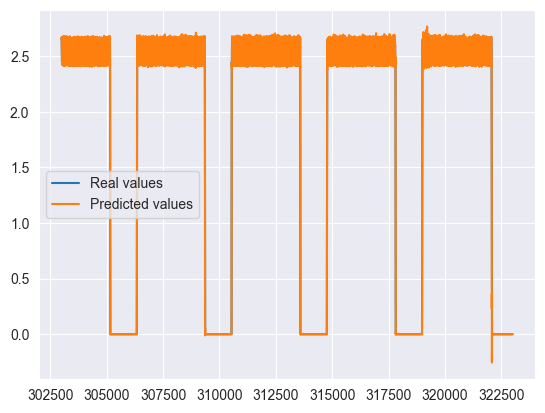

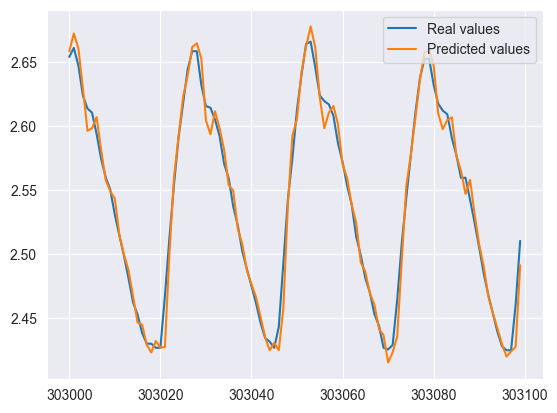

In [77]:
# Plot the predicted and real values
plt.clf()
plt.plot(zero_indexed_train_df["FIT101"][max_lag_small :][300000:320000], label="Real values")
plt.plot(fit101_ar_small.predict(start=max_lag_small, dynamic=False)[300000:320000], label="Predicted values")
plt.legend()
plt.show()

plt.clf()
plt.plot(zero_indexed_train_df["FIT101"][max_lag_small :][300000:300100], label="Real values")
plt.plot(fit101_ar_small.predict(start=max_lag_small , dynamic=False)[300000:300100], label="Predicted values")
plt.legend()
plt.show()

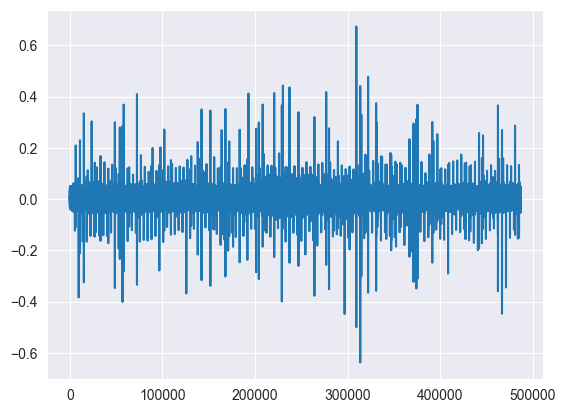

In [81]:
plt.clf()

train_residuals = get_ar_residuals(fit101_ar_small, zero_indexed_train_df["FIT101"])
plt.plot(train_residuals)

Interestingly, this model is a much better fit than the ones using larger time windows. This might due to the fact that the correlation between signals is much stronger for smaller lags. We will now use differencing to calculate the residuals.

C:\Users\micha\AppData\Local\Temp\ipykernel_42640\142035047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_indexed_train_df["FIT101_diff"].iloc[0] = zero_indexed_train_df["FIT101"].iloc[0]


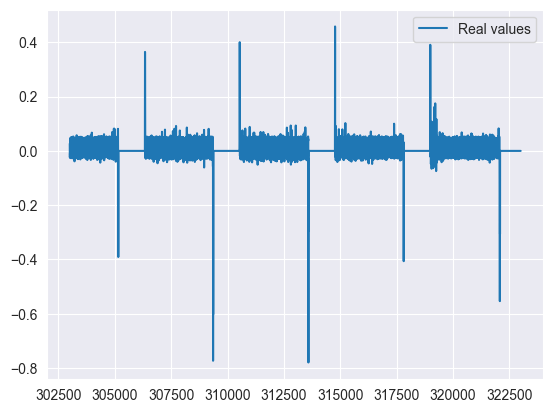

In [82]:
# Use differencing to calculate the residuals
zero_indexed_train_df["FIT101_diff"] = zero_indexed_train_df["FIT101"].diff()
zero_indexed_train_df["FIT101_diff"].iloc[0] = zero_indexed_train_df["FIT101"].iloc[0]

# Plot the differenced signal
plt.clf()
plt.plot(zero_indexed_train_df["FIT101_diff"][max_lag_small :][300000:320000], label="Real values")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

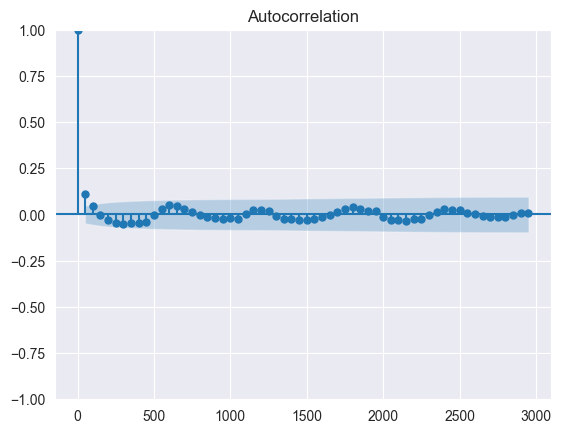

In [83]:
# Plot the autocorrelations for the relevant attributes
start_time = 10000
plotting_time = 3000
plt.clf()
plot_acf(zero_indexed_train_df[["FIT101_diff"]].iloc[: plotting_time,:], lags=list(range(0, plotting_time, 50)))
plt.show()

In this case, the signals are autocorrelated withing a very short time frame. Thus, we will use a small lag for the autoregression model.

In [84]:
# Use autoregression to predict the next values based on the previous ones
from statsmodels.tsa.ar_model import AutoReg
lags = [1, 2, 5, 10]
fit101_ar_diff = AutoReg(zero_indexed_train_df["FIT101_diff"], lags=lags).fit()
max_lag = np.max(lags)

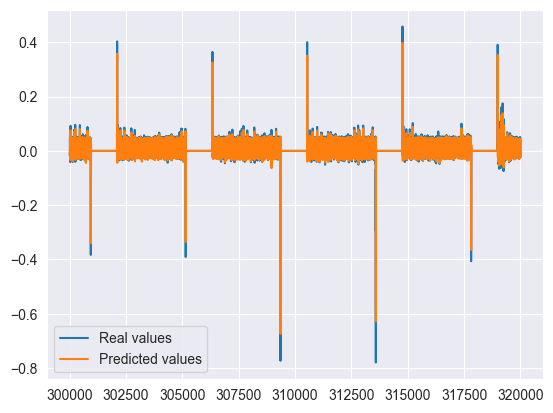

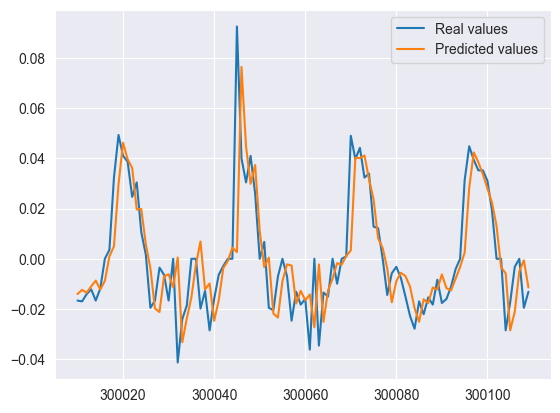

In [85]:
# Plot the predicted and real values
plt.clf()
plt.plot(zero_indexed_train_df["FIT101_diff"][max_lag:][300000:320000], label="Real values")
plt.plot(fit101_ar_diff.predict(start=max_lag, dynamic=False)[300000:320000], label="Predicted values")
plt.legend()
plt.show()

plt.clf()
plt.plot(zero_indexed_train_df["FIT101_diff"][max_lag:][300000:300100], label="Real values")
plt.plot(fit101_ar_diff.predict(start=max_lag, dynamic=False)[300000:300100], label="Predicted values")
plt.legend()
plt.show()

The predictive power has not increased. One of the possible causes is that the signal is not periodic enough and the differencing does not help to make it more periodic. We will now look at the signal LIT101.

<Figure size 640x480 with 0 Axes>

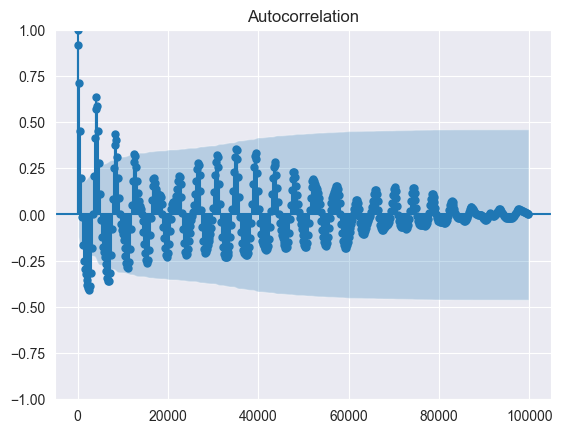

<Figure size 640x480 with 0 Axes>

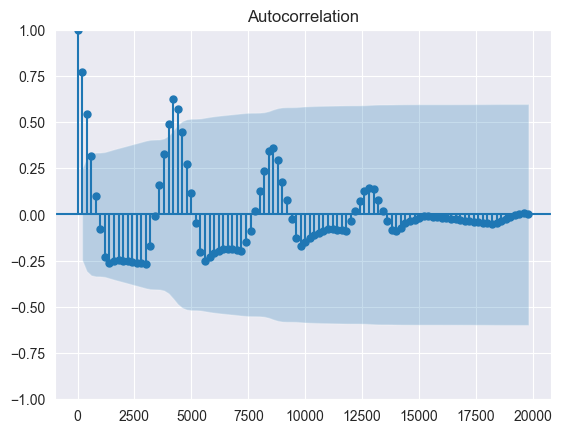

In [47]:
# Plot the autocorrelations for the relevant attributes
start_time = 10000
plotting_time = 100000
plt.clf()
plot_acf(relevant_train_data_df[["LIT101"]].iloc[: plotting_time,:], lags=list(range(0, plotting_time, 200)))
plt.show()

<Figure size 640x480 with 0 Axes>

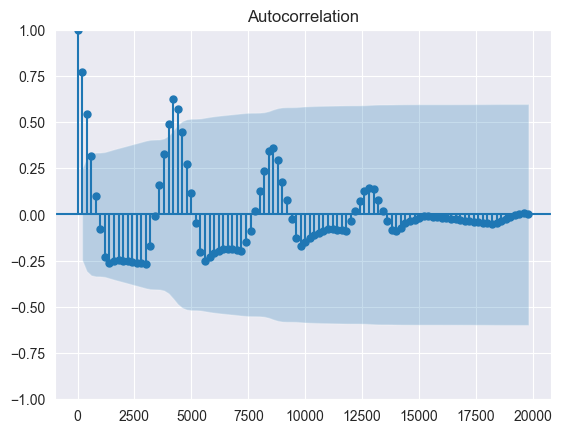

In [49]:
plotting_time2 = 20000
plt.clf()
plot_acf(relevant_train_data_df[["FIT101"]].iloc[: plotting_time2,:], lags=list(range(0, plotting_time2, 200)))
plt.show()

In [93]:
# Use autoregression to predict the next values based on the previous ones
from statsmodels.tsa.ar_model import AutoReg
zero_indexed_train_df = relevant_train_data_df.reset_index(inplace=False, drop=True)
# Use lags that correspond to high values of autocorrelation
lags = [1500, 2000, 2500, 3000, 3250, 3500, 3750, 4000]
lit101_ar = AutoReg(zero_indexed_train_df["LIT101"], lags=lags).fit()
max_lag = np.max(lags)

In [92]:
print(lit101_ar.predict(start=max_lag, dynamic=False))
print(zero_indexed_train_df["LIT101"][max_lag:])

4000      507.974286
4001      507.667810
4002      507.364667
4003      506.687102
4004      506.256492
             ...    
496795    537.311835
496796    537.298829
496797    537.289847
496798    536.855971
496799    536.428332
Length: 492800, dtype: float64
4000      270.1375
4001      270.0197
4002      270.0982
4003      270.0197
4004      269.4702
            ...   
496795    523.0430
496796    522.9645
496797    522.8860
496798    522.9252
496799    522.8467
Name: LIT101, Length: 492800, dtype: float64


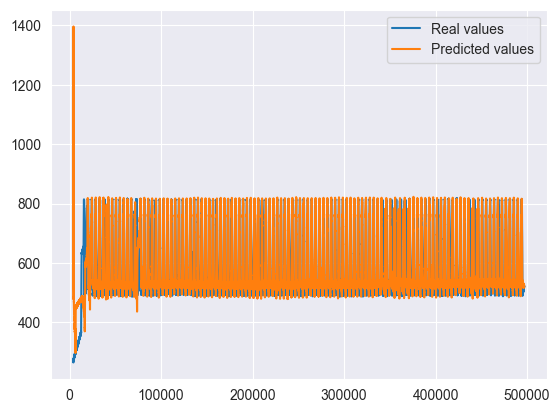

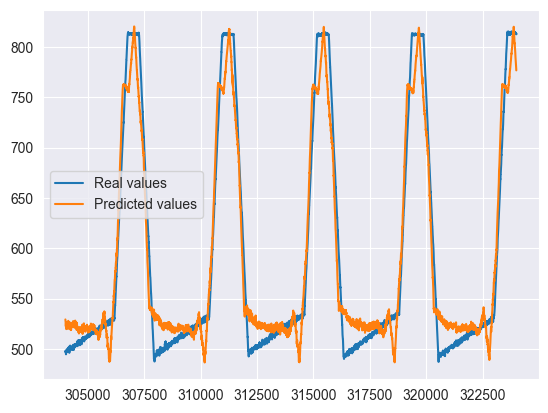

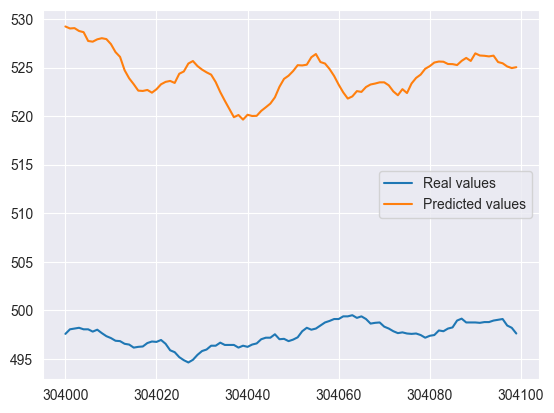

In [94]:
# Plot the predicted and real values
plt.clf()
plt.plot(zero_indexed_train_df["LIT101"][max_lag:], label="Real values")
plt.plot(lit101_ar.predict(start=max_lag, dynamic=False), label="Predicted values")
plt.legend()
plt.show()

plt.clf()
plt.plot(zero_indexed_train_df["LIT101"][max_lag:][300000:320000], label="Real values")
plt.plot(lit101_ar.predict(start=max_lag, dynamic=False)[300000:320000], label="Predicted values")
plt.legend()
plt.show()

plt.clf()
plt.plot(zero_indexed_train_df["LIT101"][max_lag:][300000:300100], label="Real values")
plt.plot(lit101_ar.predict(start=max_lag, dynamic=False)[300000:300100], label="Predicted values")
plt.legend()
plt.show()

In [95]:
print(lit101_ar.params)

const           356.929666
LIT101.L1500     -0.081413
LIT101.L2000     -0.021294
LIT101.L2500     -0.091631
LIT101.L3000     -0.076599
LIT101.L3250     -0.037499
LIT101.L3500      0.146928
LIT101.L3750     -0.660412
LIT101.L4000      1.219117
dtype: float64


In [104]:
# Use autoregression to predict the next values based on the previous ones
from statsmodels.tsa.ar_model import AutoReg
zero_indexed_train_df = relevant_train_data_df.reset_index(inplace=False, drop=True)
lags = [1, 2, 3, 5]
lit101_ar = AutoReg(zero_indexed_train_df["LIT101"], lags=lags).fit()
max_lag = np.max(lags)

In [ ]:
# Plot the predicted and real values
plt.clf()
plt.plot(zero_indexed_train_df["LIT101"][max_lag:], label="Real values")
plt.plot(lit101_ar.predict(start=max_lag, dynamic=False), label="Predicted values")
plt.legend()
plt.show()

plt.clf()
plt.plot(zero_indexed_train_df["LIT101"][max_lag:][300000:320000], label="Real values")
plt.plot(lit101_ar.predict(start=max_lag, dynamic=False)[300000:320000], label="Predicted values")
plt.legend()
plt.show()

plt.clf()
plt.plot(zero_indexed_train_df["LIT101"][max_lag:][300000:300100], label="Real values")
plt.plot(lit101_ar.predict(start=max_lag, dynamic=False)[300000:300100], label="Predicted values")
plt.legend()
plt.show()

Again, the small difference between the smaller and larger time windows shows that the signal is not periodic enough to make a long-term prediction useful.

In [43]:
# Predict the test data
ar_test = AutoReg(zero_index_test_df ["FIT101"], lags=lags)
ar_test_pred = ar_test.predict(fit101_ar.params, start=0, dynamic=False)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 5)

In [44]:

print(ar_test_pred)
print(zero_index_test_df[["FIT101"]].to_numpy().squeeze())
residuals = get_ar_residuals(ar_test, zero_index_test_df["FIT101"], fit101_ar.params)
# Plot the residuals
plt.clf()
plt.plot(residuals)
plt.show()

NameError: name 'ar_test_pred' is not defined

In [19]:
zero_indexed_val_df = relevant_val_data_df.reset_index(inplace=False, drop=False)
zero_indexed_val_df["FIT101_diff"] = zero_indexed_val_df["FIT101"].diff()

In [20]:
ar_val = AutoReg(zero_indexed_val_df["FIT101_diff"], lags=lags_small)
ar_val_pred = ar_val.predict(fit101_ar_diff .params, start=0, dynamic=False)

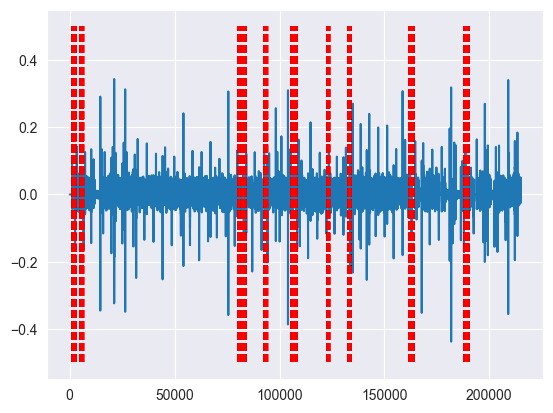

In [26]:
# Repeat the same process for the validation data
residuals_val = zero_indexed_val_df[["FIT101_diff"]].to_numpy().squeeze() - ar_val_pred
# Plot the residuals
plt.clf()
plt.plot(residuals_val)
# Get indices of ones in the labels
anomaly_indices = np.where(zero_indexed_val_df["Label"].to_numpy().squeeze() == 1)[0]
plt.vlines(anomaly_indices,  ymin=-0.5, ymax=0.5, color="red", label="Anomaly", linestyles="dashed")
plt.show()

In [4]:
# Use sklearn for autoregression
from sklearn.linear_model import ARDRegression

ard = ARDRegression()
time_window_range = 2000
# Collect arrays of the features and labels
features = []
targets = []
signal_array = relevant_train_data_df["LIT101"].to_numpy().squeeze()
for i in range(time_window_range, len(relevant_train_data_df)):
    time_window = signal_array[i-time_window_range:i-1]
    target = signal_array [i]
    features.append(time_window)
    targets.append(target)

features = np.array(features)
targets = np.array(targets)

print(features.shape)
print(targets.shape)

(484800, 1999)
(484800,)


In [5]:
print(features.shape)
print(targets.shape)

(484800, 1999)
(484800,)


In [6]:
# Train the model
ard.fit(features, targets)


ARDRegression()

[ 0.          0.          0.         ... -0.21254969 -0.18236719
  1.5703558 ]


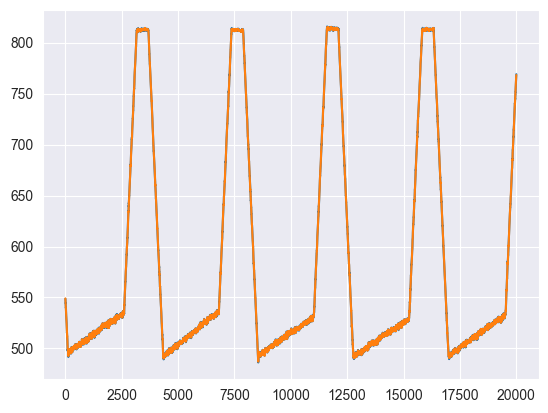

In [9]:
print(ard.coef_)
predictions = ard.predict(features)
plt.plot(predictions[300000:320000])
plt.plot(targets[300000:320000])

### 4b. Plots to study the detected anomalies

### 4c. Analysis and answers to the questions